# EDA on underreporting vs actual crime and PAS measures

---

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
from scipy.stats import pearsonr
import datetime as dt

In [2]:
# removes SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
# load data with preprocessing
df = pd.read_pickle(r"PAS_underreporting.pkl")
df = df[df["Question"] != 'XQ59CD']  # removing unnecessary question
df = df.replace({'-': np.nan, ' ': np.nan, '': np.nan, '#N/A': np.nan, "Westminster": "City of Westminster"})  # make unknown NAN
df = df.dropna()

### Notes for the PAS underreporting dataset

Only questions **BQ90D** and **BQ90DA** make sense to ask and were asked from 2015 to the beginning of 2021. We will only look at them for plotting. 

This dataset shows underreporting by ward. Most ``no_counts`` were 4 and most ``total_counts`` were 18. There is an additional column ``Total_no_prop`` to show how much a ward contributed to overall underreporting in that quartile for the entire London.

Not all boroughs are listed. 66 entries do not have a borough listed => _dropped rows_.

In [4]:
# Print simple statistics
print(df.shape)
print(df.describe())
print(df.head(20))
print(df.columns)

for col in df.columns:
    print(col)
    print(df[col].unique())
    print(len(df[col].unique()))
    print("---------------------------------------------------------------")

(4509, 8)
       total_count     no_count  Proportion_no  Total_prop_no
count  4509.000000  4509.000000    4509.000000    4509.000000
mean      1.201375     0.563983       0.477719       0.000294
std       0.492434     0.594412       0.482165       0.000345
min       1.000000     0.000000       0.000000       0.000000
25%       1.000000     0.000000       0.000000       0.000000
50%       1.000000     1.000000       0.500000       0.000323
75%       1.000000     1.000000       1.000000       0.000683
max       6.000000     3.000000       1.000000       0.002049
    Year-Month                 Borough                      ward_n Question   
0   2015-04-01    Barking and Dagenham                       Heath    BQ90D  \
1   2015-04-01                  Bexley                  Barnehurst    BQ90D   
2   2015-04-01                   Brent                    Barnhill    BQ90D   
3   2015-04-01                   Brent                      Kenton    BQ90D   
4   2015-04-01                   Bren

In [5]:
# How often does each borough show up here?
print(df["Borough"].value_counts().sort_values(ascending=False))

Borough
Richmond upon Thames      177
Brent                     165
Enfield                   163
Hounslow                  160
Hackney                   160
Merton                    159
Lewisham                  151
Harrow                    150
Barnet                    150
Haringey                  149
Waltham Forest            147
Kingston upon Thames      147
Camden                    146
Wandsworth                143
Redbridge                 142
Islington                 140
Lambeth                   140
Ealing                    139
City of Westminster       135
Sutton                    134
Tower Hamlets             132
Greenwich                 131
Croydon                   131
Havering                  130
Hammersmith and Fulham    129
Hillingdon                128
Bromley                   127
Newham                    126
Southwark                 124
Kensington and Chelsea    121
Bexley                    118
Barking and Dagenham      115
Name: count, dtype: int64


In [6]:
# DF underreporting by borough + print stats
df_ub = df.groupby(["Year-Month", "Borough"])[["total_count", "no_count", "Total_prop_no"]].sum().reset_index()
print(df_ub.describe())
print("total_count:", sum(df_ub["total_count"]), "\nno_count:", sum(df_ub["no_count"]), "\nTotal_prop_no:", sum(df_ub["Total_prop_no"]))

       total_count     no_count  Total_prop_no
count  1706.000000  1706.000000    1706.000000
mean      3.175264     1.490621       0.000778
std       2.458166     1.109371       0.000613
min       1.000000     0.000000       0.000000
25%       1.000000     1.000000       0.000323
50%       2.000000     1.000000       0.000683
75%       5.000000     2.000000       0.000969
max      17.000000     8.000000       0.004098
total_count: 5417 
no_count: 2543 
Total_prop_no: 1.3267916598294502


In [7]:
# max underreporting borough -> 0.2%
print("MAX BOROUGH")
print(df_ub.max())
print("---------------------")
print(df_ub[df_ub.Total_prop_no == df_ub.Total_prop_no.max()])
print("------------------------------------------------------")
# max underreporting ward -> 5 wards tied with 0.000969 contribution to underreporting in London City
print("MAX WARDS")
print(df.max())
print("---------------------")
print(df[df.Total_prop_no == df.Total_prop_no.max()])

MAX BOROUGH
Year-Month       2021-03-01
Borough          Wandsworth
total_count              17
no_count                  8
Total_prop_no      0.004098
dtype: object
---------------------
     Year-Month               Borough  total_count  no_count  Total_prop_no
246  2016-03-01                Merton            7         6       0.004098
718  2018-05-01              Hounslow            7         6       0.004098
725  2018-05-01  Richmond upon Thames            7         6       0.004098
839  2018-11-01               Croydon            7         6       0.004098
------------------------------------------------------
MAX WARDS
Year-Month       2021-03-01
Borough          Wandsworth
ward_n             Yiewsley
Question             BQ90DA
total_count               6
no_count                  3
Proportion_no           1.0
Total_prop_no      0.002049
dtype: object
---------------------
      Year-Month               Borough                                 ward_n   
397   2016-03-01         T

---

## PAS dataset

In [8]:
df_pas = pd.read_pickle(r"crime_data/PAS.pkl")
df_pas['Date'] = pd.to_datetime(df_pas['Date']).dt.date
df_pas = df_pas[["Date", "Borough", "Measure", "Proportion"]].copy()
print(df_pas)

            Date               Borough            Measure  Proportion
0     2023-12-31  Barking and Dagenham   "Good Job" local        0.48
1     2023-12-31                Barnet   "Good Job" local        0.47
2     2023-12-31                Bexley   "Good Job" local        0.54
3     2023-12-31                 Brent   "Good Job" local        0.49
4     2023-12-31               Bromley   "Good Job" local        0.51
...          ...                   ...                ...         ...
9307  2014-12-31                Sutton  Understand issues        0.79
9308  2014-12-31         Tower Hamlets  Understand issues        0.63
9309  2014-12-31        Waltham Forest  Understand issues        0.79
9310  2014-12-31            Wandsworth  Understand issues        0.71
9311  2014-12-31   City of Westminster  Understand issues        0.77

[9312 rows x 4 columns]


---

## Crime dataset

We will plot the total number of crimes against the number of underreported crimes. We do not have specific crime underreporting number, so we will only use the total numbers.

In [9]:
# Load data with preprocessing
df2 = pd.read_pickle(r'crime_data/london_street_with_city.pkl')
df2 = df2[~(df2["Borough"] == 'City of London')]
df2["Year"] = df2["Year"].astype(int)
df2["Year-Month"] = pd.to_datetime(df2["Year-Month"]).dt.date

In [10]:
# Grouping by crime, Pivot table to convert Crime type into columns
def create_df(df):
    crime_counts = df.groupby(['Year-Month', 'Crime type']).size().reset_index(name='Count')
    pivot_df = crime_counts.pivot_table(index='Year-Month', columns='Crime type', values='Count', aggfunc='sum', fill_value=0)
    return pivot_df

In [11]:
pivot_df = create_df(df2)
print(pivot_df)

Crime type  Anti-social behaviour  Bicycle theft  Burglary   
Year-Month                                                   
2010-12-01                  34459              0      7897  \
2011-01-01                  33542              0      9020   
2011-02-01                  32070              0      7774   
2011-03-01                  35794              0      8313   
2011-04-01                  40922              0      7596   
...                           ...            ...       ...   
2023-09-01                  21196           1650      4517   
2023-10-01                  20034           1537      4541   
2023-11-01                  17668           1160      4681   
2023-12-01                  16322            915      4957   
2024-01-01                  16505            956      5043   

Crime type  Criminal damage and arson  Drugs  Other crime  Other theft   
Year-Month                                                               
2010-12-01                          0      0 

In [12]:
def plotter(pivot_df, title_name):
    plt.figure(figsize=(12, 6))
    plt.stackplot(pivot_df.index, pivot_df.values.T, labels=pivot_df.columns)
    plt.title(f'Crime Counts Over Time in {title_name}')
    plt.xlabel('Year-Month')
    plt.ylabel('Count')
    plt.legend(loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

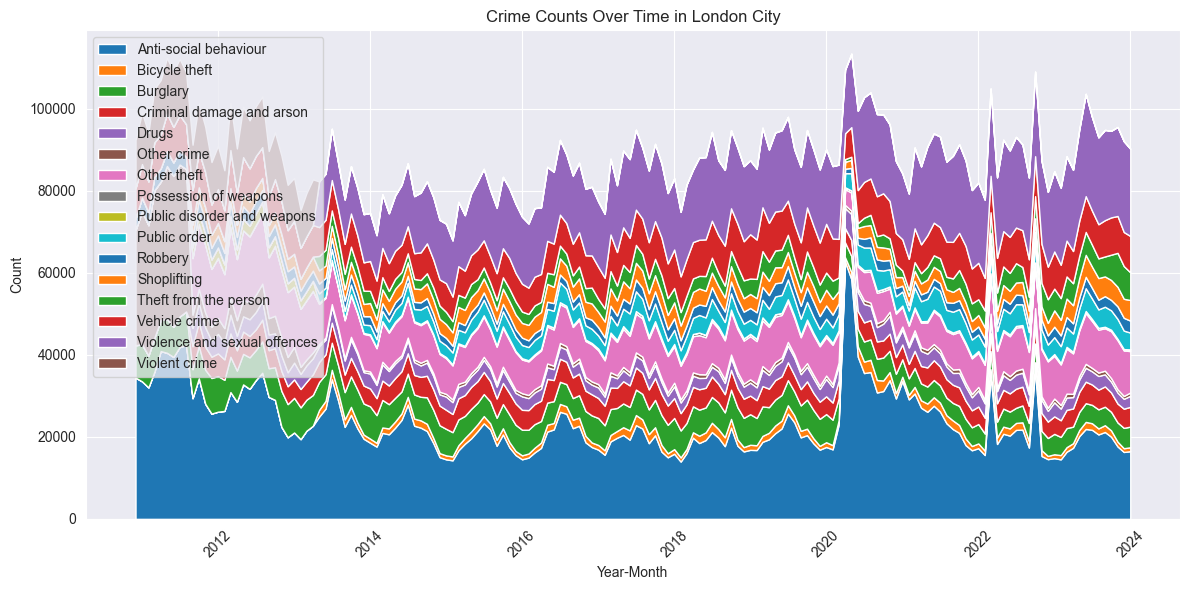

In [13]:
# Plotting total crime by crime
plotter(pivot_df, "London City")

In [14]:
# # Plotting crime by borough
# for B in df2["Borough"].unique():
#     print(B)
#     df_borough = df2[df2["Borough"] == B]
#     plotter(create_df(df_borough), B)

In [15]:
# Grouping by total crime per quartile by borough
df_london = df2.groupby(['Borough', 'Year-Month']).size().to_frame('num_crimes').reset_index()
df_london

Borough  Year-Month  num_crimes
0     Barking and Dagenham  2010-12-01        2044
1     Barking and Dagenham  2011-01-01        2292
2     Barking and Dagenham  2011-02-01        2171
3     Barking and Dagenham  2011-03-01        2505
4     Barking and Dagenham  2011-04-01        2743
...                    ...         ...         ...
5051            Wandsworth  2023-09-01        2852
5052            Wandsworth  2023-10-01        3001
5053            Wandsworth  2023-11-01        2700
5054            Wandsworth  2023-12-01        2716
5055            Wandsworth  2024-01-01        2723

[5056 rows x 3 columns]

In [16]:
# Create the plot
fig = px.line(df_london, x='Year-Month', y='num_crimes', color='Borough', 
              title='Number of Crimes per Borough Over Time')

# Update layout for better visualization
fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Number of Crimes',
    legend_title='Borough',
    template='plotly_white',
    width=1200,
    height=800
)

# Show the plot
fig.show()

---

# Causality determination

To determine the causality between trust and underreporting and to see if trust can be used to predict underreporting, we do the following:

- EDA and correlation coefficients
- Statistical tests (regression analysis for statistical significance & Granger causality test)
- Predictive modeling (with trust as an independent variable

## EDA and correlation coefficients

---

### Borough level

Limit each dataframe to ``2021-03-01`` (underreporting's end) and ``2015-07-01`` (PAS' beginning).

In [17]:
df_pas2 = df_pas[(df_pas["Date"] <= dt.date(2021, 3, 1)) & (df_pas["Date"] >= dt.date(2015, 4, 1))]

df_pas2["Year-Month"] = pd.to_datetime( pd.DatetimeIndex(df_pas2.Date) + pd.DateOffset(1) ).date
df_pas2.drop("Date", inplace=True, axis=1)
df_pas2[df_pas2["Year-Month"] == dt.date(2015, 7, 1)]

Borough            Measure  Proportion  Year-Month
8640  Barking and Dagenham   "Good Job" local        0.61  2015-07-01
8641                Barnet   "Good Job" local        0.66  2015-07-01
8642                Bexley   "Good Job" local        0.73  2015-07-01
8643                 Brent   "Good Job" local        0.62  2015-07-01
8644               Bromley   "Good Job" local        0.74  2015-07-01
...                    ...                ...         ...         ...
8859                Sutton  Understand issues        0.80  2015-07-01
8860         Tower Hamlets  Understand issues        0.73  2015-07-01
8861        Waltham Forest  Understand issues        0.82  2015-07-01
8862            Wandsworth  Understand issues        0.71  2015-07-01
8863   City of Westminster  Understand issues        0.80  2015-07-01

[224 rows x 4 columns]

In [18]:
df_london2 = df_london[(df_london["Year-Month"] <= dt.date(2021, 3, 1)) & (df_london["Year-Month"] >= dt.date(2015, 4, 1))]
df_london2['Year-Month'] = pd.to_datetime(df_london2['Year-Month'])

# Change the time so the instances are quarterly
df_london2['Quarter'] = df_london2['Year-Month'].dt.to_period('Q').dt.start_time

df_quarterly = df_london2.groupby(['Quarter', 'Borough']).agg({'num_crimes': 'sum'}).reset_index()
df_quarterly.rename(columns={"Quarter": "Year-Month"}, inplace=True)
df_quarterly["Year-Month"] = pd.to_datetime(df_quarterly["Year-Month"]).dt.date

df_quarterly[df_quarterly["Year-Month"] == dt.date(2015, 7, 1)]

Year-Month                 Borough  num_crimes
32  2015-07-01    Barking and Dagenham        5701
33  2015-07-01                  Barnet        8182
34  2015-07-01                  Bexley        4064
35  2015-07-01                   Brent        8379
36  2015-07-01                 Bromley        6838
37  2015-07-01                  Camden        9305
38  2015-07-01     City of Westminster       15690
39  2015-07-01                 Croydon        9121
40  2015-07-01                  Ealing        9447
41  2015-07-01                 Enfield        7622
42  2015-07-01               Greenwich        7008
43  2015-07-01                 Hackney        9259
44  2015-07-01  Hammersmith and Fulham        6373
45  2015-07-01                Haringey        8409
46  2015-07-01                  Harrow        4348
47  2015-07-01                Havering        5338
48  2015-07-01              Hillingdon        8029
49  2015-07-01                Hounslow        7382
50  2015-07-01               Islington        8514
51  2015-07-01  Kensington and Chelsea        6507
52  2015-07-01    Kingston upon Thames        3480
53  2015-07-01                 Lambeth       11568
54  2015-07-01                Lewisham        8030
55  2015-07-01                  Merton        4140
56  2015-07-01                  Newham       10123
57  2015-07-01               Redbridge        6238
58  2015-07-01    Richmond upon Thames        3671
59  2015-07-01               Southwark        9764
60  2015-07-01                  Sutton        3202
61  2015-07-01           Tower Hamlets       11214
62  2015-07-01          Waltham Forest        7327
63  2015-07-01              Wandsworth        7213

In [19]:
df_ub['Year-Month'] = pd.to_datetime(df_ub['Year-Month'])

# Change the time so the instances are quarterly
df_ub['Quarter'] = df_ub['Year-Month'].dt.to_period('Q').dt.start_time

df_ub_quarter = df_ub.groupby(['Quarter', 'Borough']).agg({'Total_prop_no': 'sum', "no_count": 'sum', "total_count": 'sum'}).reset_index()
df_ub_quarter.rename(columns={"Quarter": "Year-Month"}, inplace=True)
df_ub_quarter["Year-Month"] = pd.to_datetime(df_ub_quarter["Year-Month"]).dt.date

df_ub_quarter[df_ub_quarter["Year-Month"] == dt.date(2015, 7, 1)]

Year-Month                 Borough  Total_prop_no  no_count  total_count
30  2015-07-01    Barking and Dagenham       0.002049         3            3
31  2015-07-01                  Barnet       0.002049         3            3
32  2015-07-01                  Bexley       0.000000         0            1
33  2015-07-01                   Brent       0.002049         3            3
34  2015-07-01                 Bromley       0.001366         2            2
35  2015-07-01                  Camden       0.003415         5            5
36  2015-07-01     City of Westminster       0.001366         2            2
37  2015-07-01                 Croydon       0.002732         4            6
38  2015-07-01                  Ealing       0.002049         3            3
39  2015-07-01                 Enfield       0.001366         2            3
40  2015-07-01               Greenwich       0.002732         4            4
41  2015-07-01                 Hackney       0.000683         1            2
42  2015-07-01  Hammersmith and Fulham       0.002049         3            3
43  2015-07-01                Haringey       0.000683         1            1
44  2015-07-01                  Harrow       0.002732         4            4
45  2015-07-01                Havering       0.000683         1            1
46  2015-07-01              Hillingdon       0.001366         2            3
47  2015-07-01                Hounslow       0.002049         3            4
48  2015-07-01               Islington       0.002732         4            4
49  2015-07-01  Kensington and Chelsea       0.000683         1            1
50  2015-07-01    Kingston upon Thames       0.000683         1            2
51  2015-07-01                 Lambeth       0.002049         3            3
52  2015-07-01                Lewisham       0.002049         3            3
53  2015-07-01                  Merton       0.002049         3            4
54  2015-07-01                  Newham       0.002732         4            4
55  2015-07-01               Redbridge       0.001366         2            2
56  2015-07-01    Richmond upon Thames       0.005464         8            9
57  2015-07-01               Southwark       0.002049         3            3
58  2015-07-01                  Sutton       0.002049         3            3
59  2015-07-01           Tower Hamlets       0.000683         1            1
60  2015-07-01          Waltham Forest       0.002732         4            5
61  2015-07-01              Wandsworth       0.001366         2            2

In [20]:
# Get unique combinations of 'Year-Month' and 'Borough'
unique_keys = pd.MultiIndex.from_product([
    pd.concat([df_pas2['Year-Month'], df_quarterly['Year-Month'], df_ub_quarter['Year-Month']]).unique(),
    pd.concat([df_pas2['Borough'], df_quarterly['Borough'], df_ub_quarter['Borough']]).unique()
], names=['Year-Month', 'Borough'])

cartesian_product_df = pd.DataFrame(index=unique_keys).reset_index()

# Merge each DataFrame with the cartesian product
merged_df0 = cartesian_product_df.merge(df_pas2, on=['Year-Month', 'Borough'], how='left')
merged_df1 = merged_df0.merge(df_quarterly, on=['Year-Month', 'Borough'], how='left')
merged_df = merged_df1.merge(df_ub_quarter, on=['Year-Month', 'Borough'], how='left')

# Limit timeframe
merged_df2 = merged_df[(merged_df["Year-Month"] <= dt.date(2021, 3, 1)) & (merged_df["Year-Month"] >= dt.date(2015, 7, 1))]

# For those with no underreporting values, fill in zeroes
merged_df2[["Total_prop_no", "no_count", "total_count"]] = merged_df2[["Total_prop_no", "no_count", "total_count"]].fillna(0)

In [21]:
# Save pickle -- final underreporting/crime/PAS file on borough level
merged_df2.to_pickle(r"underreporting_crime_pas.pkl")

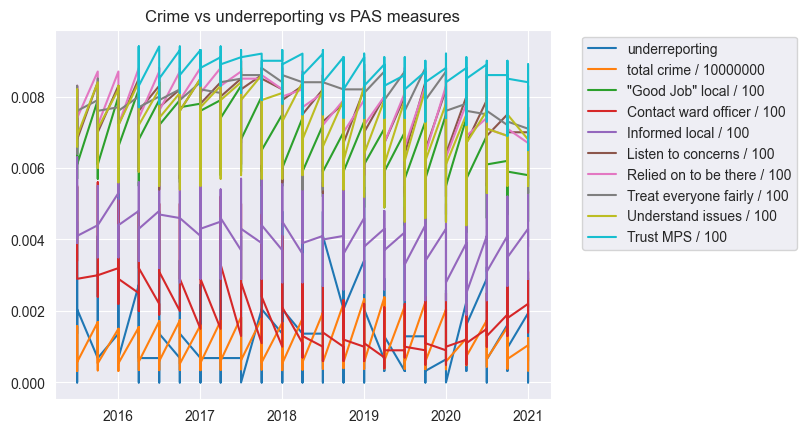

In [22]:
# Plotting total underreporting vs crime vs PAS
df_plot = merged_df2.copy()
df_plot["Crime / 10000000"] = df_plot["num_crimes"] / 10000000

plt.plot(df_plot["Year-Month"], df_plot["Total_prop_no"], label="underreporting")
plt.plot(df_plot["Year-Month"], df_plot["Crime / 10000000"], label="total crime / 10000000")

for measure in df_plot["Measure"].unique():
    df_measure = df_plot[df_plot["Measure"] == measure]
    df_measure[f"{measure} / 100"] = df_measure["Proportion"] / 100
    plt.plot(df_measure["Year-Month"], df_measure[f"{measure} / 100"], label=f"{measure} / 100")

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.title("Crime vs underreporting vs PAS measures")
plt.show()

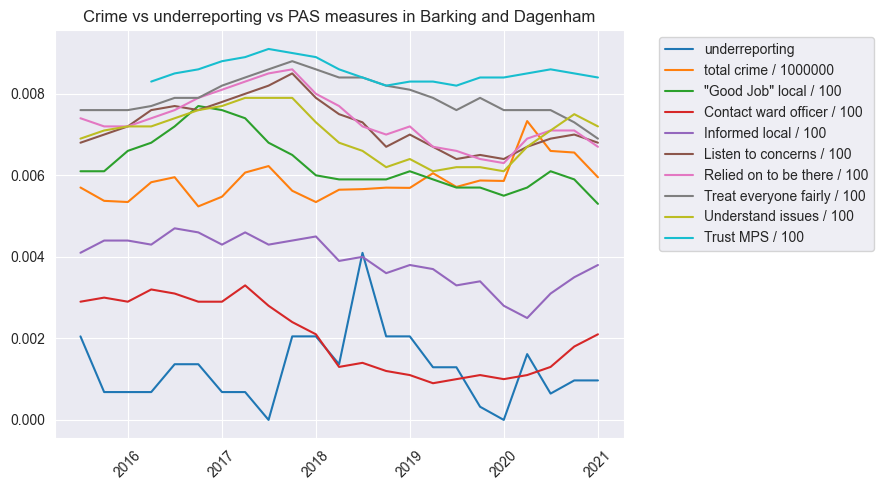

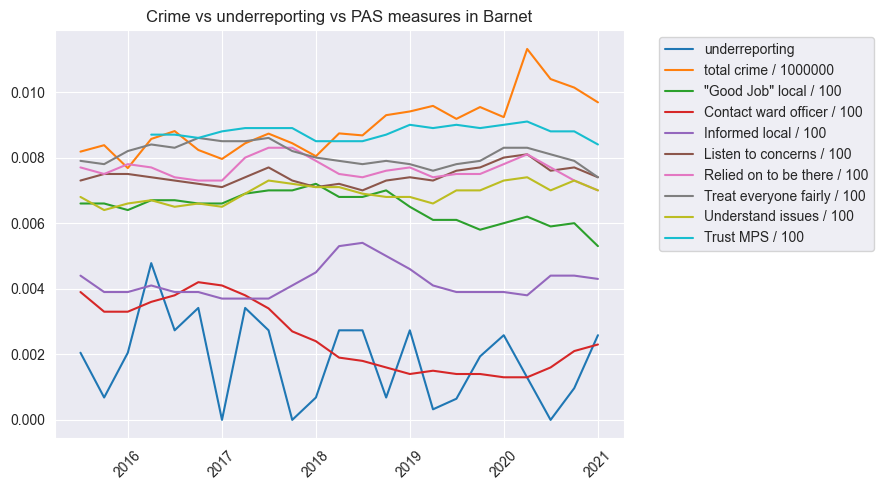

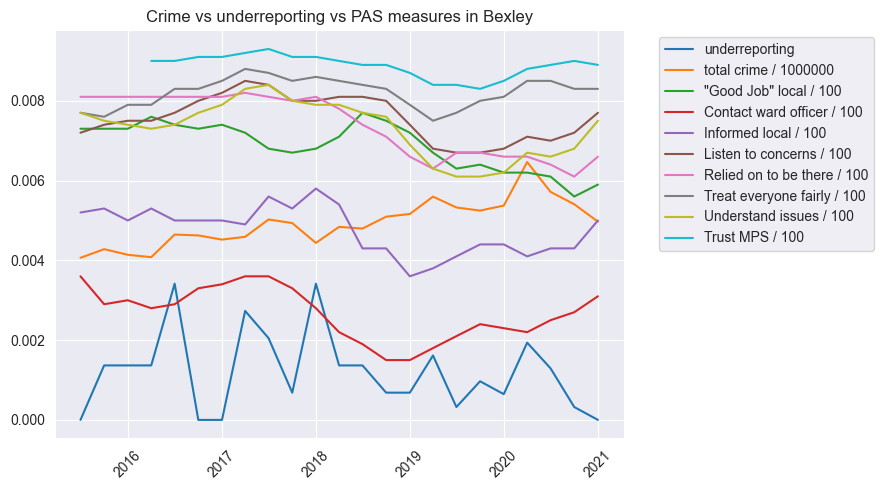

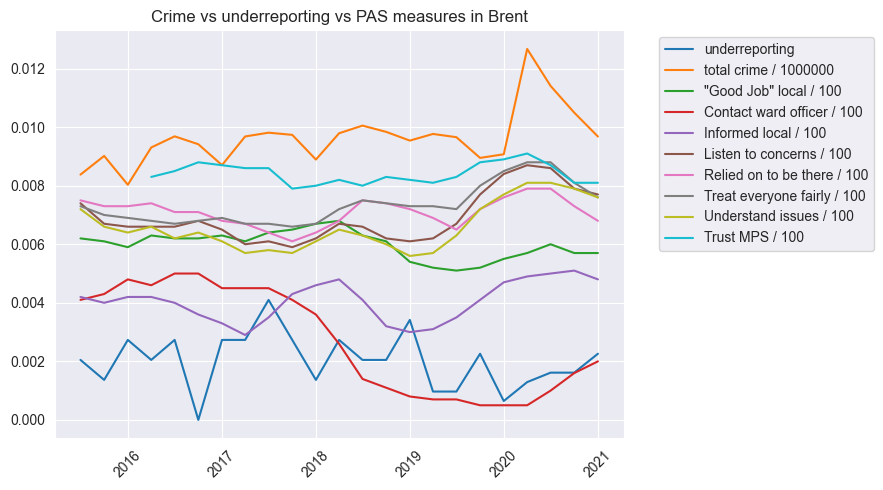

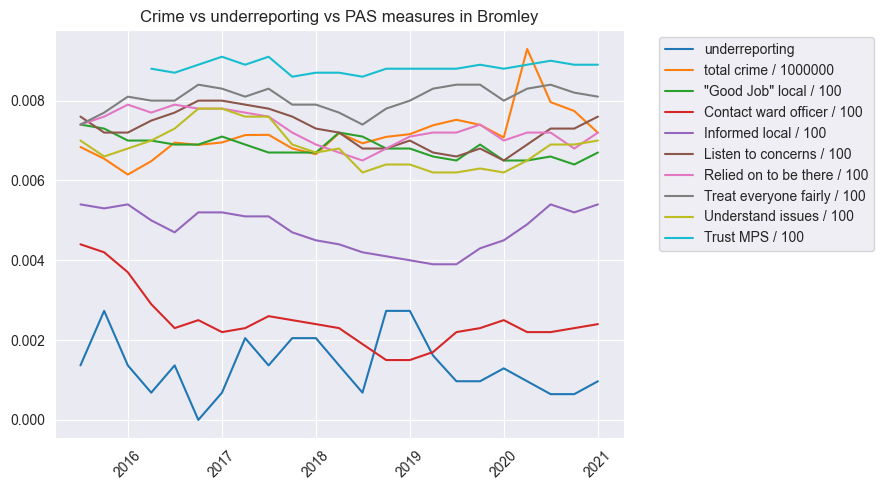

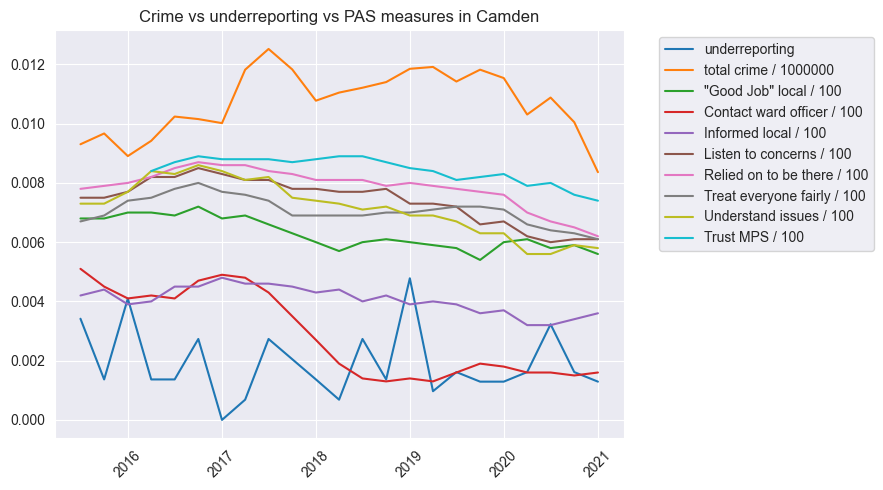

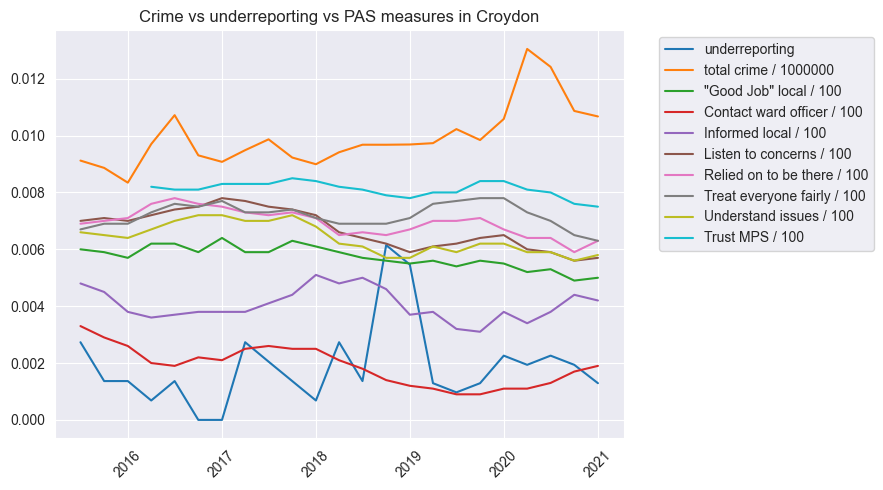

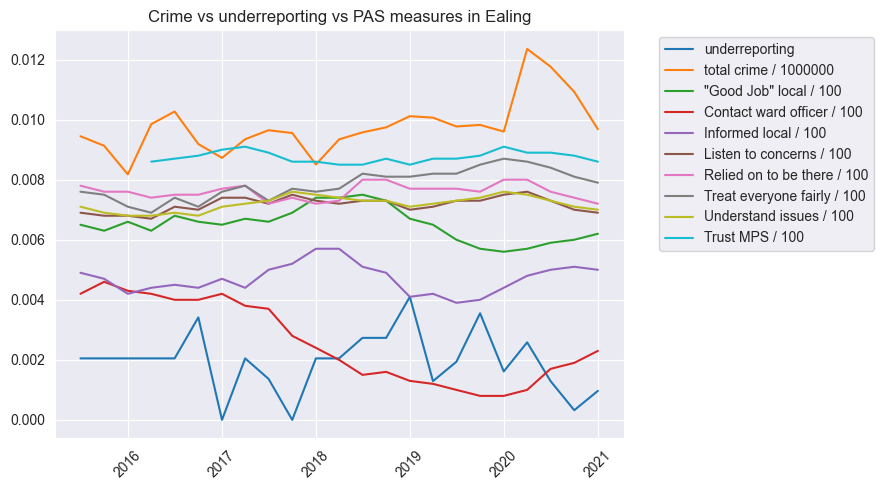

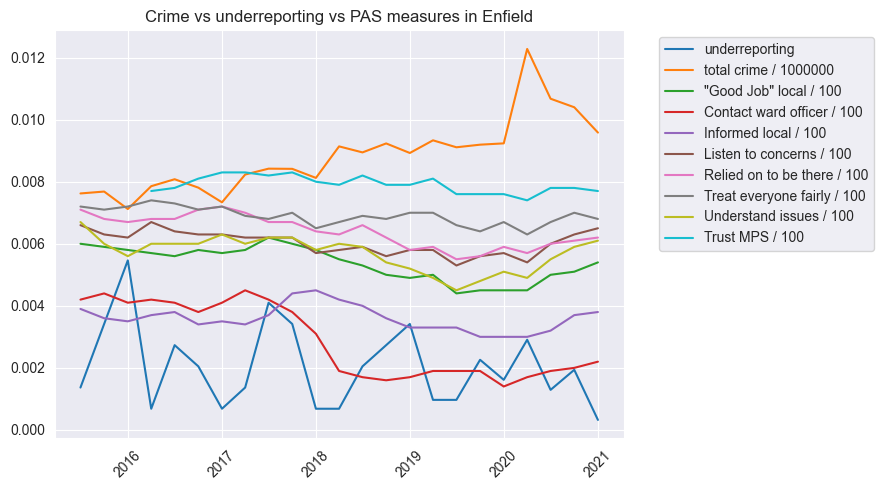

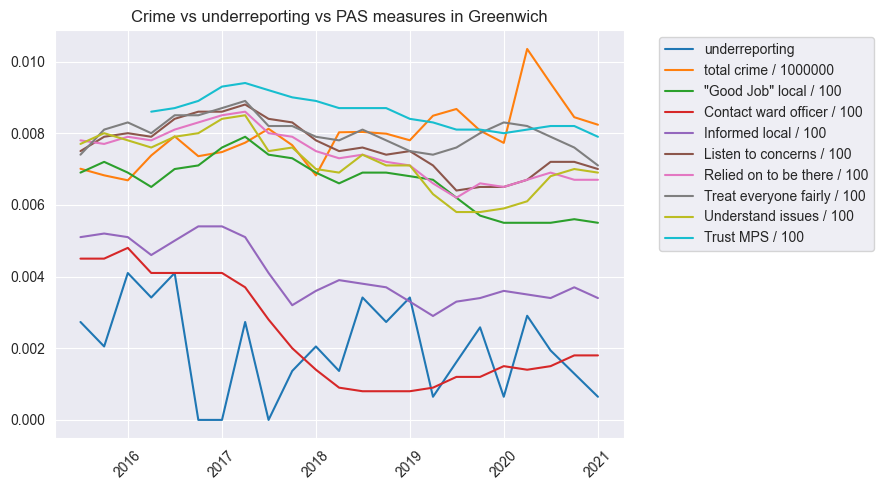

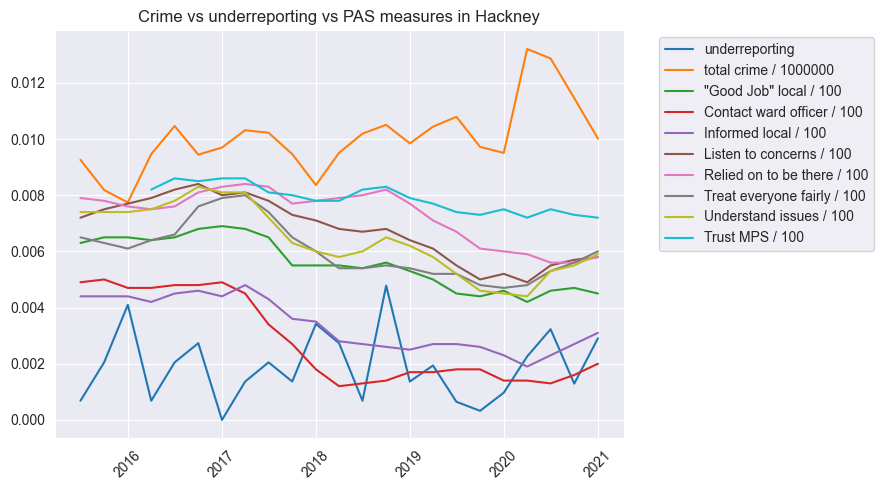

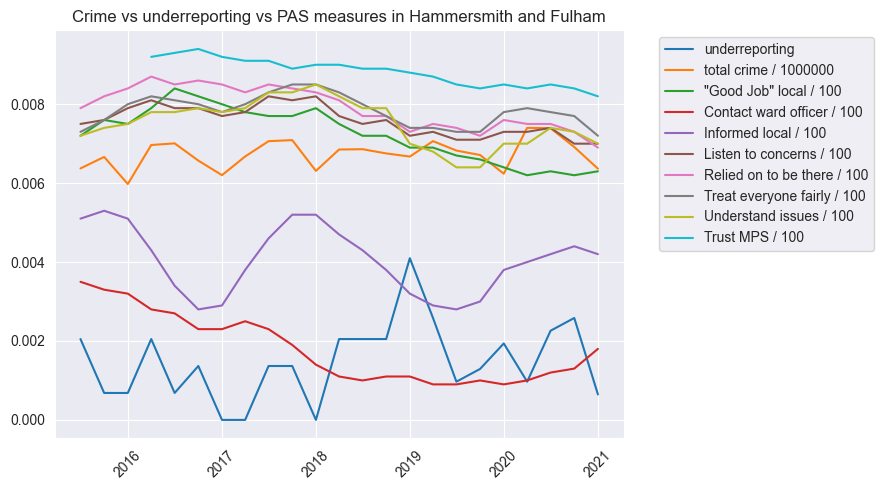

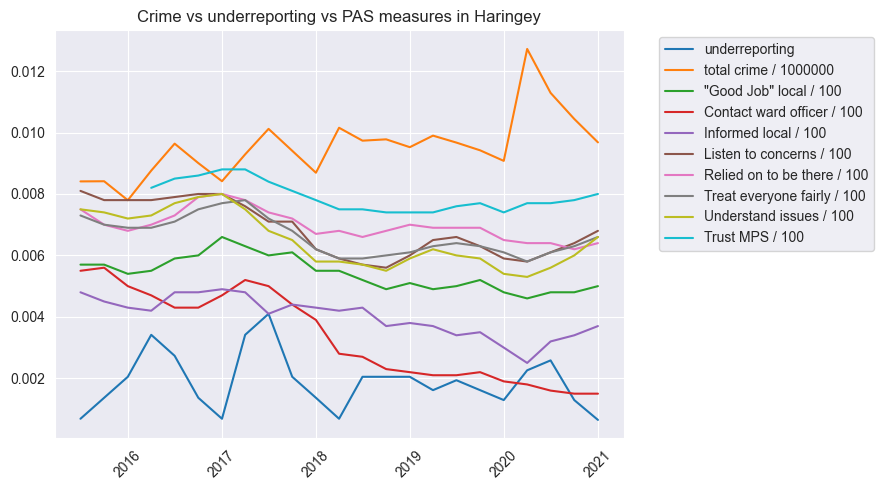

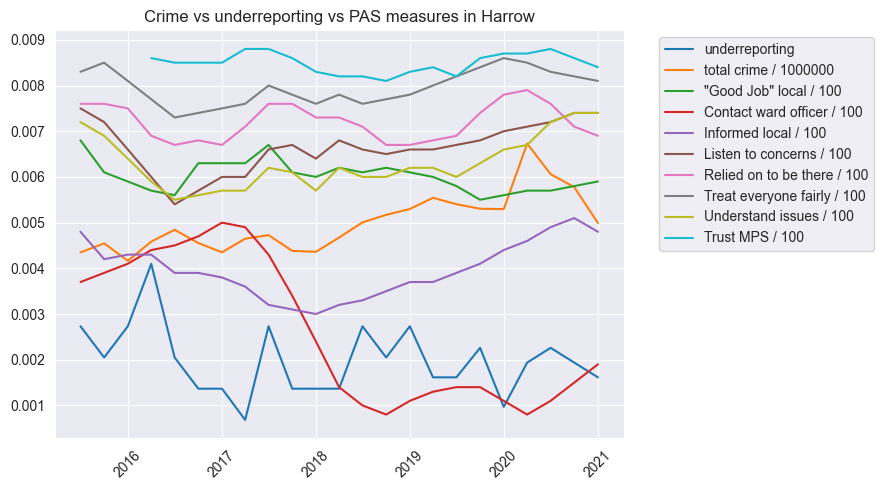

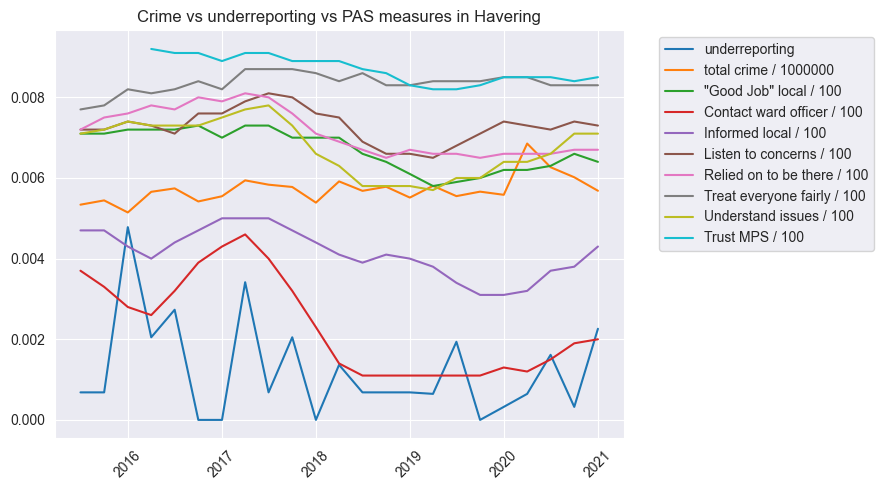

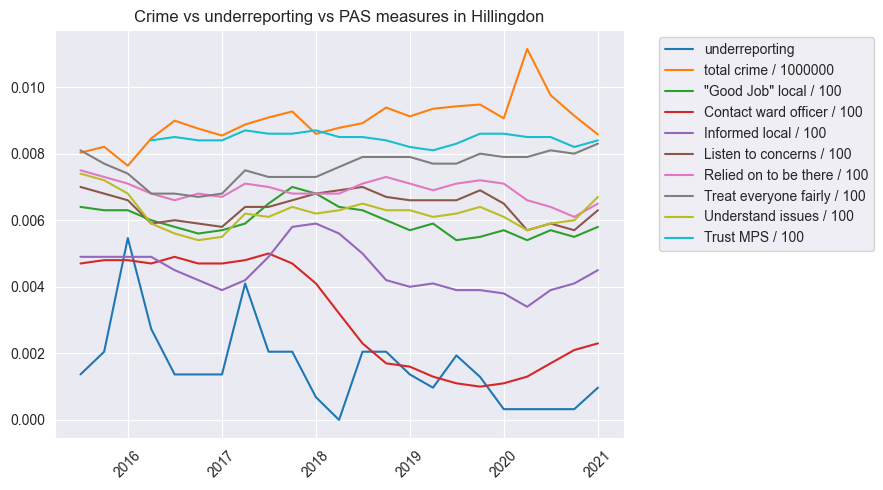

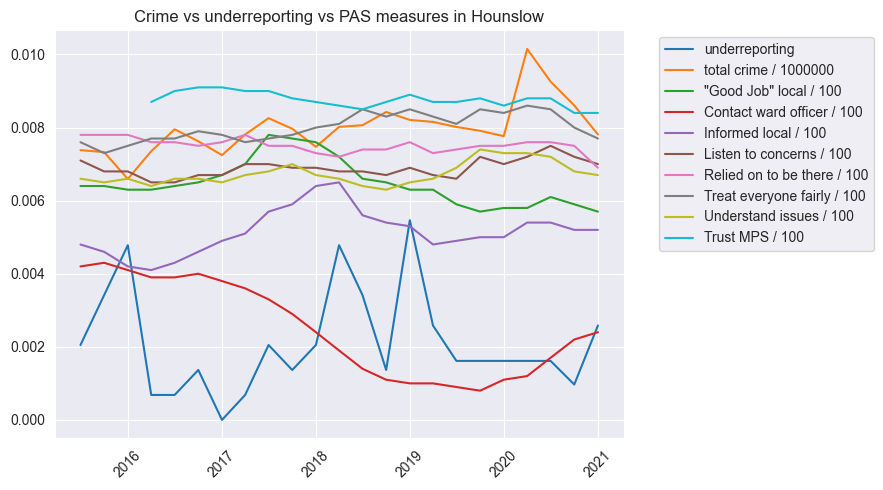

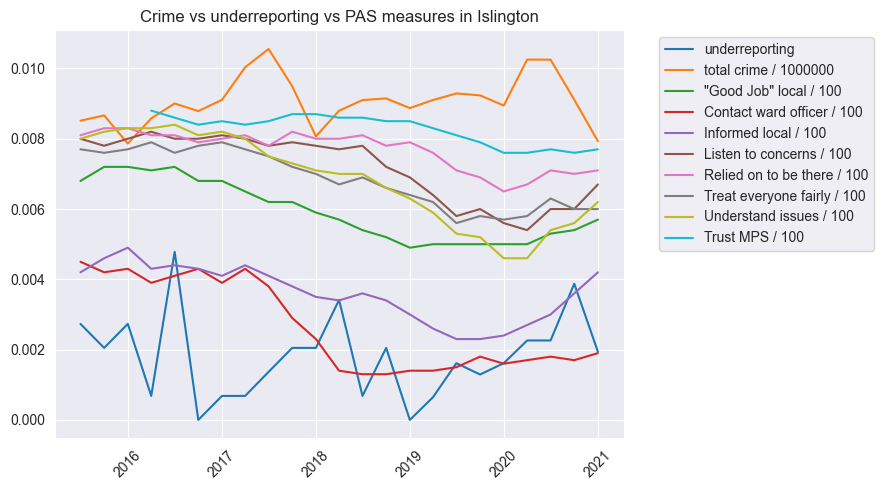

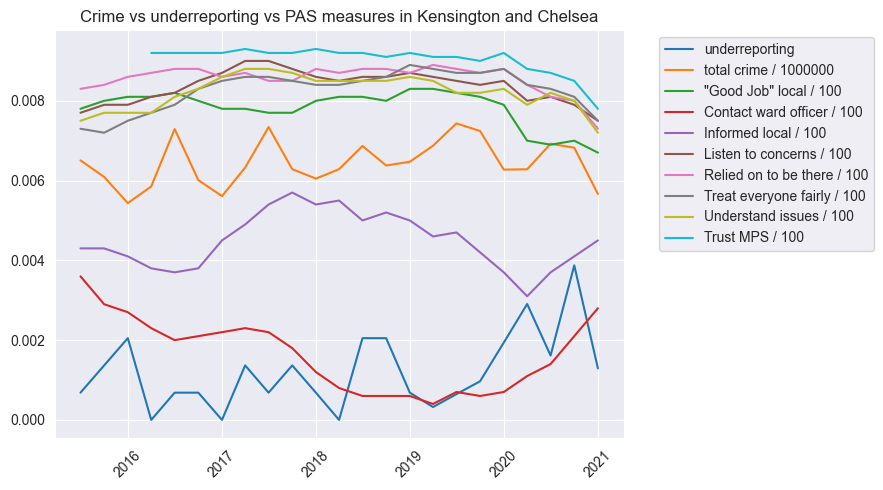

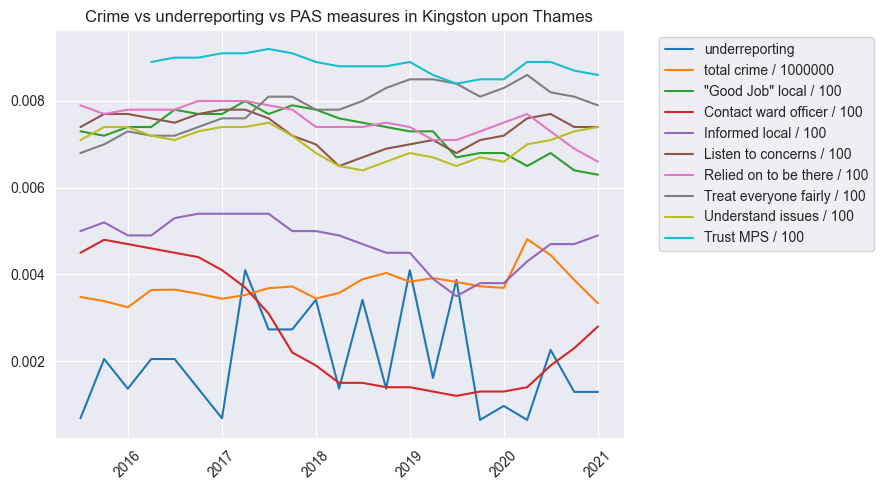

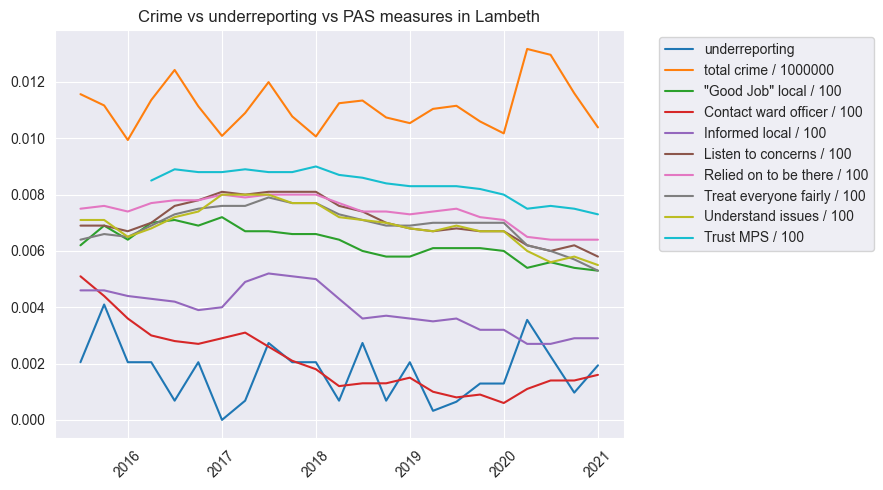

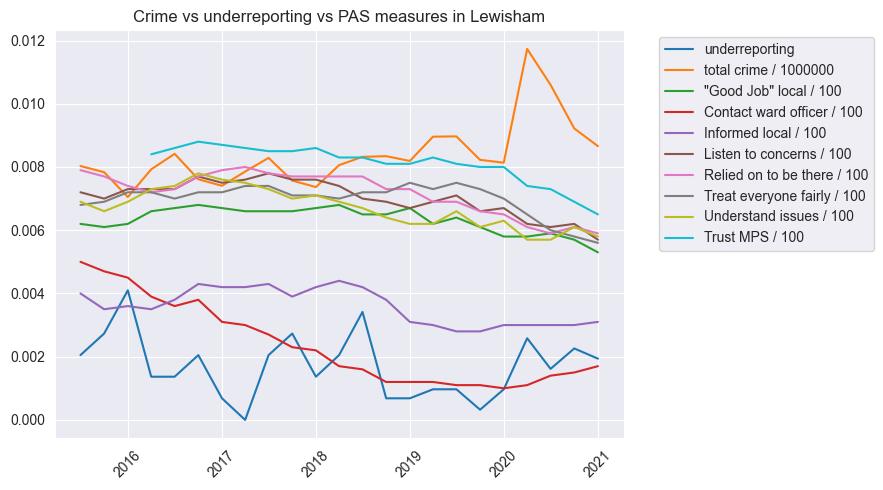

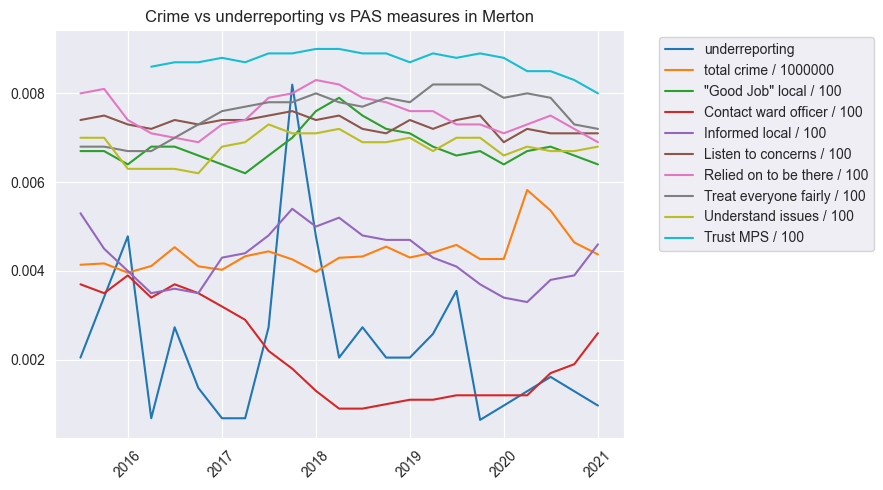

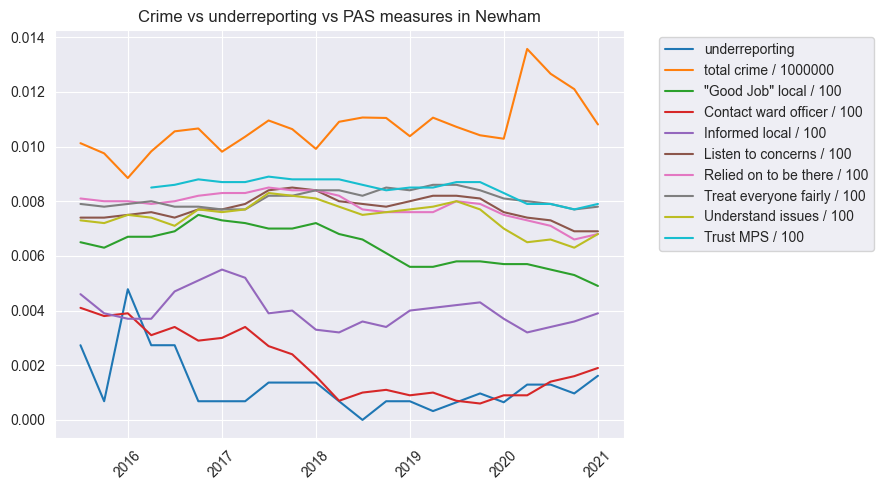

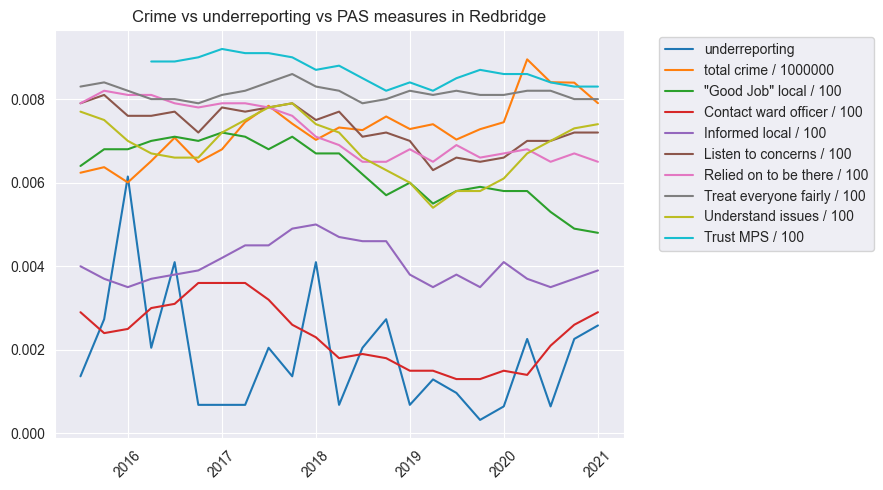

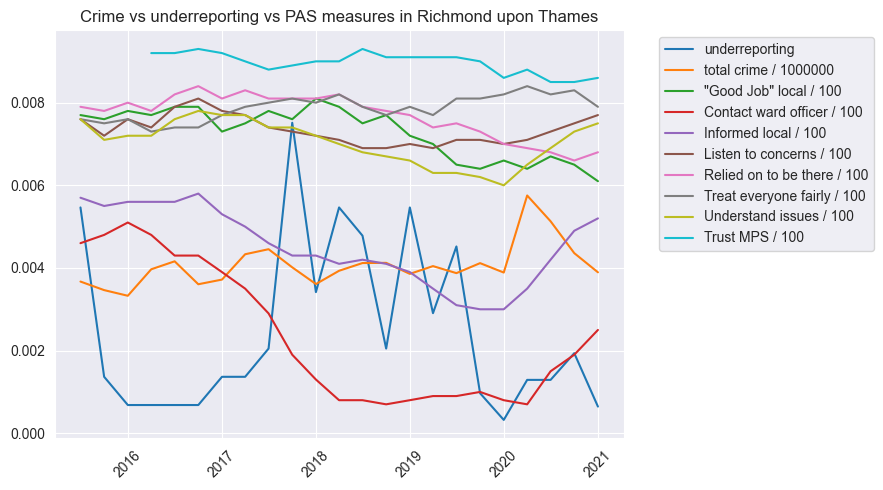

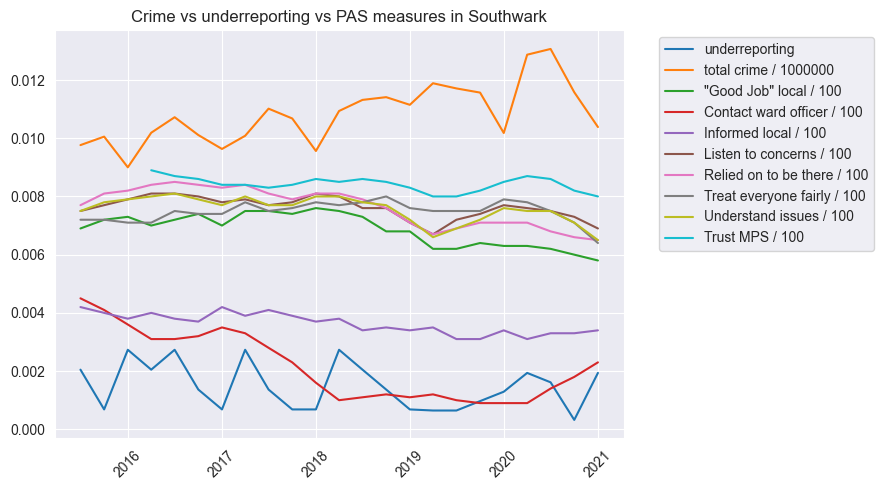

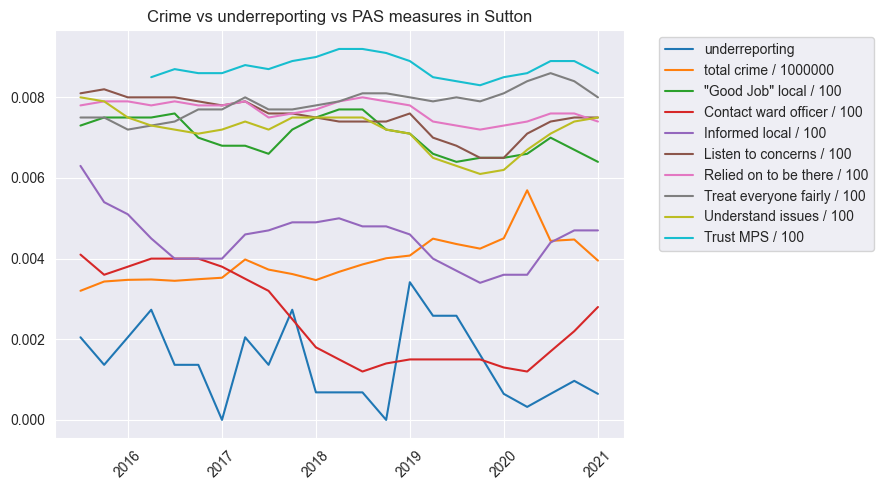

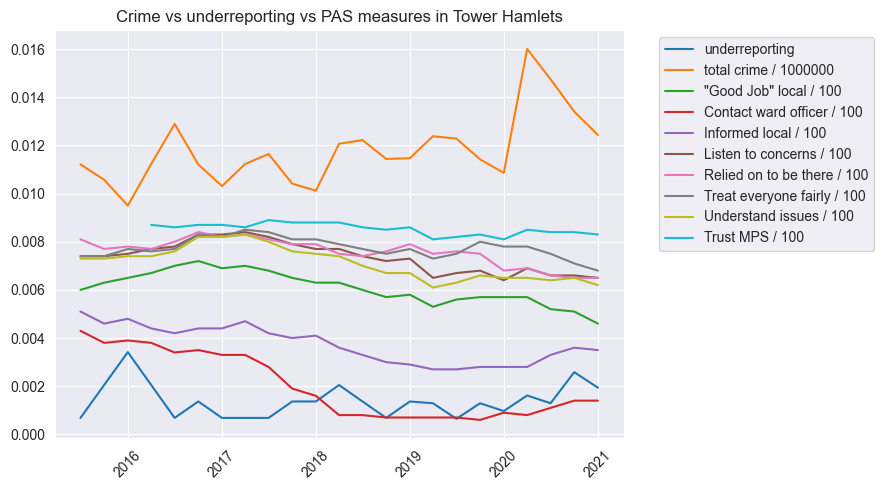

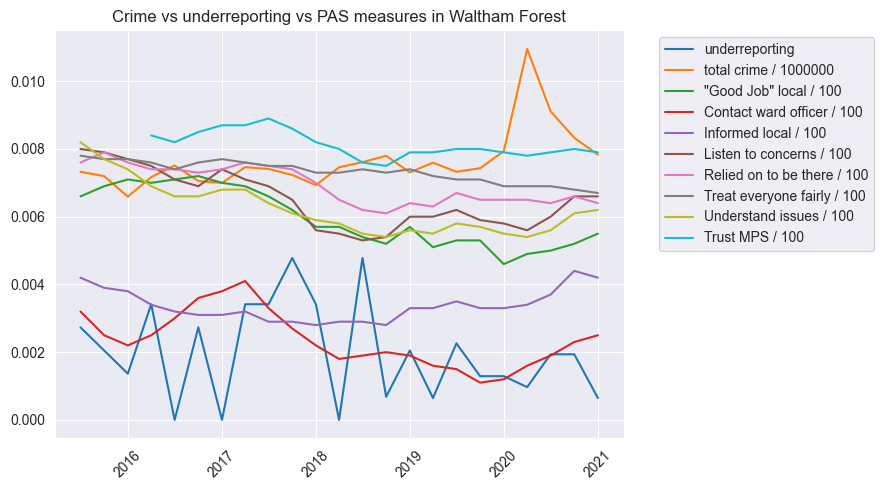

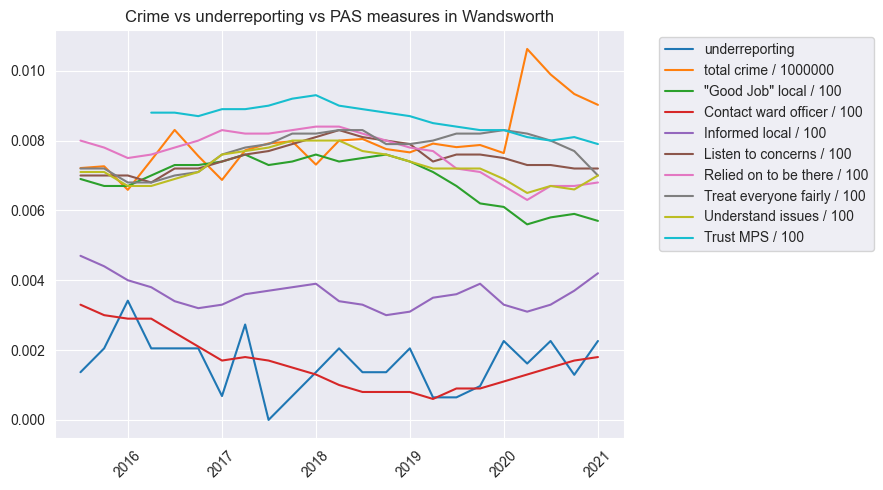

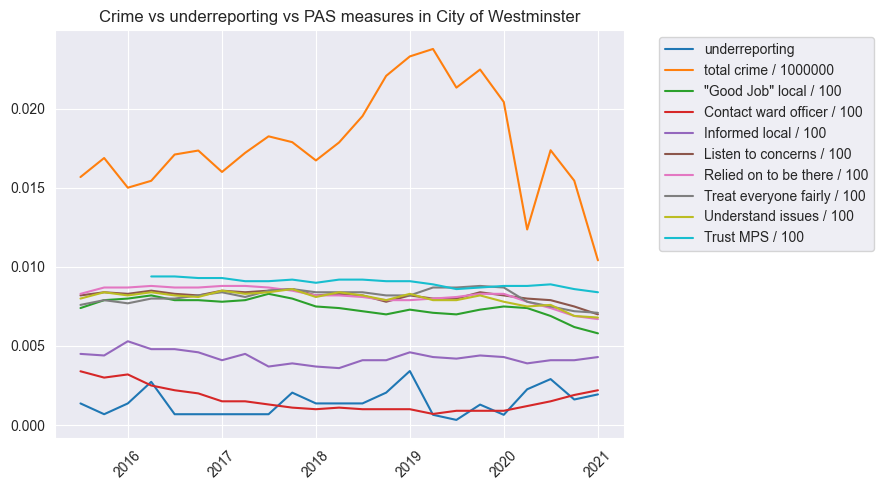

In [26]:
# Iterate over unique boroughs
for B in df_plot["Borough"].unique():
    df_plot2 = df_plot[df_plot["Borough"] == B]
    df_plot2["Crime / 1000000"] = df_plot2["num_crimes"] / 1000000
    
    # Plotting
    plt.figure(figsize=(9,5))
    plt.plot(df_plot2["Year-Month"], df_plot2["Total_prop_no"], label="underreporting")
    plt.plot(df_plot2["Year-Month"], df_plot2["Crime / 1000000"], label="total crime / 1000000")
    
    for measure in df_plot2["Measure"].unique():
        df_measure = df_plot2[df_plot2["Measure"] == measure]
        df_measure[f"{measure} / 100"] = df_measure["Proportion"] / 100
        plt.plot(df_measure["Year-Month"], df_measure[f"{measure} / 100"], label=f"{measure} / 100")
    
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.title(f"Crime vs underreporting vs PAS measures in {B}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### Ward level

In [24]:
# # Loading data and creating new columns
# df_load = pd.read_pickle(r"crime_data\PAS_ward.pkl")
# df_load = df_load[df_load["Measure"] == "Trust MPS"]
# 
# df_under_ward = df.groupby("Year-Month")["Total_prop_no"].sum().reset_index()
# df_pas_ward = df_load.groupby("Year-Month")["Proportion"].mean().reset_index()  # taking average instead of sum
# df_pas_ward["Trust / 100"] = df_pas_ward["Proportion"] / 100
# 
# plt.plot(df_under_ward["Year-Month"], df_under_ward["Total_prop_no"], label="underreporting")
# plt.plot(df_pas_ward["Year-Month"], df_pas_ward["Trust / 100"], label="PAS trust / 100")
# plt.legend(loc='upper left')
# plt.show()